In [1]:
!nvidia-smi

Sun Apr 14 14:08:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.15.0


In [3]:
!pip install -q tensorflow==2.3.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.3.0


In [4]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [5]:
!pip install -Uqr models/official/requirements.txt

  Preparing metadata (setup.py) ... done


In [1]:
# restart runtime
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv(' https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',compression= 'zip',low_memory = False)
df.shape


(1306122, 3)

In [4]:
df.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


<Axes: title={'center': 'target distribution'}, ylabel='Frequency'>

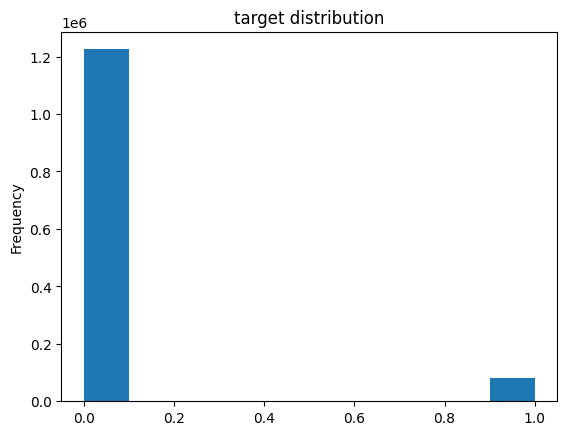

In [5]:
df.target.plot(kind = 'hist' , title = 'target distribution')

the labels distributions are skewed

##Training and Evaluation

In [6]:
train_df , remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify= df.target.values) # stratify take care of skewness
valid_df , _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify= remaining.target.values) # stratify take care of skewness
train_df.shape, valid_df.shape


((9795, 3), (972, 3))

In [7]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values,train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))
  for text, label in train_data.take(1):
    print(text)
    print(label)


tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Pre-trained BERT Model from TensorFlow H


In [8]:
"""
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0,1] # here we have only 2 class, we can change it based on the number of classes
max_seq_length = 128
train_batch_size = 32
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2" , trainable = True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # to check if bert is sensative to lower case or not
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)



In [9]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you ?')

['hi', '##,', 'how', 'are', 'you', '?']

In [10]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you ?'))

[7632, 29623, 2129, 2024, 2017, 1029]

## Tokenize and Preprocess Text for BERT

In [11]:
# This provides a function to convert row to input features and label
#mask =[1,1,0,0,...] * token vector

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):

  example = classifier_data_lib.InputExample (guid=None ,
                                              text_a= text.numpy(),
                                              text_b= None,
                                              label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0,example,label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)






##  Wrap a Python Function into a TensorFlow op for Eager Execution

In [12]:
def to_feature_map(text, label):

  input_ids, input_mask , segment_ids, label_id = tf.py_function(to_feature, inp= [text,label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x={
      'input_word_ids': input_ids,
      'input_mask':input_mask,
      'input_type_ids': segment_ids
  }

  return (x, label_id)





## Create a TensorFlow Input Pipeline with `tf.data`

In [13]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls= tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))


  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls= tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))


In [14]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [15]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Adding a Classification Head to the BERT Layer

In [16]:
# Building the model from #https://www.kaggle.com/models/tensorflow/bert/tensorFlow2/en-uncased-l-12-h-768-a-12/2?tfhub-redirect=true
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids ")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids ])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = "output")(drop)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask' : input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)

  return model


## Fine-Tune BERT for Text Classification

In [17]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics= [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids  (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                              

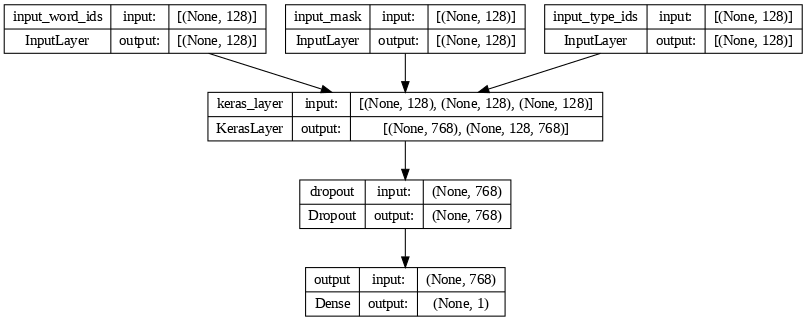

In [18]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [19]:
# Train model
epochs = 4
history = model.fit(train_data, validation_data= valid_data, epochs=epochs, verbose=1)

Epoch 1/4
306/306 [==============================] - 285s 795ms/step - loss: 0.1799 - binary_accuracy: 0.9318 - val_loss: 0.1204 - val_binary_accuracy: 0.9594
Epoch 2/4
306/306 [==============================] - 248s 809ms/step - loss: 0.1024 - binary_accuracy: 0.9612 - val_loss: 0.1341 - val_binary_accuracy: 0.9583
Epoch 3/4
306/306 [==============================] - 250s 815ms/step - loss: 0.0615 - binary_accuracy: 0.9766 - val_loss: 0.1772 - val_binary_accuracy: 0.9542
Epoch 4/4
306/306 [==============================] - 252s 820ms/step - loss: 0.0293 - binary_accuracy: 0.9890 - val_loss: 0.1980 - val_binary_accuracy: 0.9573


## Evaluate the BERT Text Classification Model

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

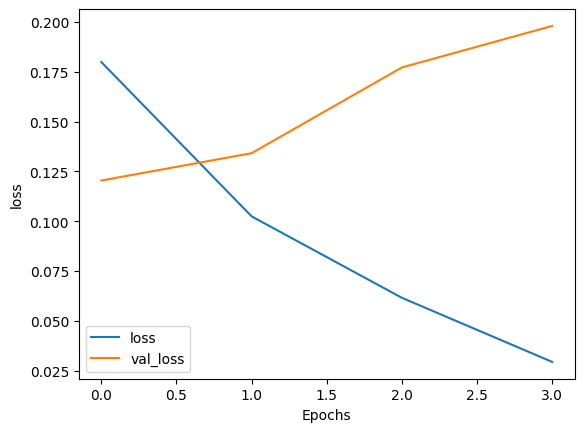

In [22]:
plot_graphs(history, 'loss')

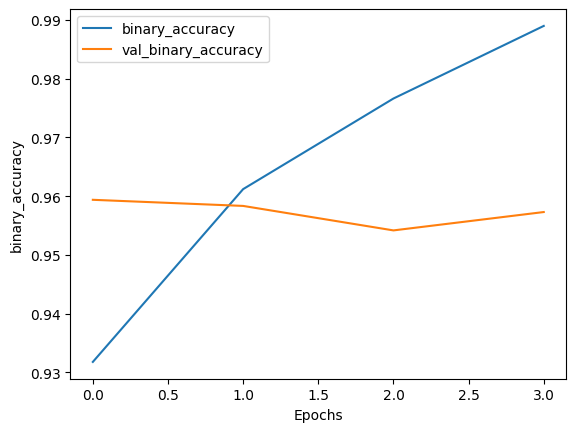

In [23]:
plot_graphs(history, 'binary_accuracy')

In [35]:
sample_example = ["saba is a good girl", " hate you", "insult people"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5  # between 0 and 1

results = ['insincere' if pred >= threshold else 'sincere' for pred in preds]
print(results)

3/3 [==============================] - 0s 23ms/step
['sincere', 'insincere', 'insincere']
